#Exam for the PhD Course in Machine Learning, A.A. 2022/2023
## Classification of Quantum States
### Diego Maragnano

Given a density matrix $\rho$ describing a quantum state, we can retrieve all the features of the quantum state. In particular, one might be interested in understanding if the state is pure or mixed.
Reconstructing the entire density matrix is a complex task from an experimental point of view, since the number of necessary measurements grows exponentially with the number of the parties of the system.
However, the experimental reconstruction of the reduced density matrices is much easier, and using only the latter to classify the original state would be a relevant step toward a faster characterization of the quantum states generated by properly designed quantum devices.
The goal of this project is to classify 2-qubit quantum states as pure or mixed starting from the reduced density matrices of the single qubits using a deep learning model.
We begin by reviewing the necessary concepts about the density matrix formalism in quantum mechanics, focussing on the 2-qubit case. We briefly describe the structure of the dataset, and look at some of the features. The description of the deep learning algorithm is the main part of this notebook. Finally, we look at the results and the metrics traditionally used to evaluate the performance of a classifier.

We start by reviewing the density matrix formalism necessary to understand the content of the dataset.
We consider a quantum systems of _n_ qu*d*its, i.e. a system composed of _n_ *d*-level carriers of information.
A **pure** quantum **state** of _n_ qu*d*its is represented by a normalized vector belonging to a complex Hilbert space: $\lvert \psi \rangle \in \mathcal{H}$, $\langle \psi \lvert \psi \rangle = 1$, $\text{dim} \left( \mathcal{H} \right) = d^{n}$.
The dimension of the Hilbert space is equal to the number fo complex numbers necessary to completely characterize the quanutm state (alternatively, we can say that we need $d^{2n}$ real parameters).
We can also descrie quantum states using the **density operator**, defined as the outer product of the state vector with itself $\hat{\rho} = \lvert \psi \rangle \langle \psi \rvert$.
The density operator has some peculiar features:

- $\rho$ is Hermitian: $\rho = \rho^{\dagger}$;
- $\rho$ is postive: $\rho \ge 0$;
- $\rho$ has trace 1: $\text{Tr} \left[ \rho \right] = 1$.

Once we choose a basis, the density operator $\hat{\rho}$ is represented by a $d^{2n} \times d^{2n}$ complex matrix, or again, we need $d^{2n}$ real numbers to completely characterize the state.
The density matrix formalism is particularly useful to deal with **mixed states** of a quantum system. A system is in a mixed states when it is in a statistical ensemble of different pure states. This means that we have a certain probability of finding the system in one of the different pure states.
More precisely, we say that the system is in a mixed state if we can write it as a convex combination of pure states, that is:
\begin{equation}
\hat{\rho} = \sum_i p_i \lvert \psi_i \rangle \langle \psi_i \rvert, \hspace{0.2cm} \sum_i p_i = 1.
\end{equation}
Consider a simple example just for clarity. Suppose that we have a probability $p_1 = 1/4$ of finding the system in the state $\lvert \psi_1 \rangle$, and a probability $p_2 = 3/4$ of finding the system in the state $\lvert \psi_2 \rangle$. Then the system is in a mixed state, written as:
\begin{equation}
\hat{\rho} = p_1 \lvert \psi_1 \rangle \langle \psi_1 \rvert  + p_2 \lvert \psi_2 \rangle \langle \psi_2 \rvert = \frac{1}{4} \lvert \psi_1 \rangle \langle \psi_1 \rvert  + \frac{3}{4} \lvert \psi_2 \rangle \langle \psi_2 \rvert.
\end{equation}

Now we focus on the 2-qubit case, where $d=2, n=2$, and the density matrix is a $4 \times 4$ complex matrix. We call the two qubits $A$ and $B$ respectively.
We can get the density matrix of a single qubit by discarding the state of the other. This can be done by means of the partial trace operation. If $\rho_{AB}$ is the 2-qubit density matrix, then the **reduced density matrix of subsystem $A$** is:

\begin{equation}
\hat{rho}_A = \text{Tr}_B \left[ \rho_{AB} \right] = \sum_j \left( I_A \otimes \langle j \rvert_B \right) \rho_{AB} \left( I_A \otimes \lvert j \rangle_B \right)
\end{equation}

where $\left\{ \rvert j \rangle \right\}$ is any orthonormal basis for the Hilbert space $\mathcal{H}_B$ of subsystem $B$.
The **reduced density matrix of subsystem $B$** is:

\begin{equation}
\hat{\rho}_B = \text{Tr}_A \left[ \rho_{AB} \right] = \sum_i \left( \langle i \rvert_A \otimes I_B \right) \rho_{AB} \left( \lvert i \rangle_A \otimes I_B \right)
\end{equation}

where $\left\{ \rvert i \rangle \right\}$ is any orthonormal basis for the Hilbert space $\mathcal{H}_A$ of subsystem $A$.

We can now proceed with the description of the dataset and the deep learning algorithm.
Frst of all, we import the necessary dependencies.

In [1]:
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import Adam
from torch.nn import BCELoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score

We now analyze the dataset.
As we will see in the following, the dataset is composed of 50000 samples.
The features are the real parameters describing the two single-qubit density matrices. Hence, we have 8 features per sample.
Since we want to do binary classification, the label can be 0 or 1. They are stored in the last column of the dataset.
Now we import the dataset, split it into train, validation, and test, and finally create the DataLoaders for PyTorch.
The class **CSVDataset** loads the data from a .txt file as a Numpy array, slices it into features and target, and reshape them properly.
The **get_splits** method allows the user to set the fraction of the dataset that will be used for the validation and the test (and thus the training one).
The **prepare_data** method prints the number of samples of the entire dataset, split the dataset, and create the DataLoaders.
In our case we decide to apply the following splitting: train 80%, validation 10%, test 10%.
The training and validation sets are divided into batches of size 32, while the size of the batches of the test set is 1024.
All the three sets are shuffled before splitting.

In [2]:
class CSVDataset(Dataset):

    def __init__(self, path):

        df = np.loadtxt(path)
        print('Shape of the dataset:', np.shape(df))
        print('Number of samples:', np.shape(df)[0])

        self.X = df[:, :-1]
        print('Number of features:', np.shape(self.X)[1])
        self.y = df[:, -1]

        self.X = self.X.astype('float32')

        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    def get_splits(self, n_valid=0.1, n_test=0.1):

        valid_size = round(n_test * len(self.X))
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - valid_size - test_size

        return random_split(self, [train_size, valid_size, test_size])


def prepare_data(path):

    dataset = CSVDataset(path)

    train, valid, test = dataset.get_splits()

    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    valid_dl = DataLoader(valid, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=True)
    return train_dl, valid_dl, test_dl

We now load the .txt file containing the data, create the DataLoaders, and then print the number of samples of each set.

In [3]:
filename = 'data_extended.txt'
train_dl, valid_dl, test_dl = prepare_data(filename)
print('#### TRAIN - VALIDATION - TEST SPLITTING #####')
print('Number of training samples:', len(train_dl.dataset))
print('Number of validation samples:', len(valid_dl.dataset))
print('Number of test samples:', len(test_dl.dataset))

Shape of the dataset: (50000, 9)
Number of samples: 50000
Number of features: 8
#### TRAIN - VALIDATION - TEST SPLITTING #####
Number of training samples: 40000
Number of validation samples: 5000
Number of test samples: 5000


Before procceding with the deep learning model, we can visualize the features.
As we said, the features are the 8 real elements characterizing the reduced density matrices (i.e. 4 for each single-qubit density matrix).
To this end, we define a **feature_array_to_density_matrix** function that takes as input a feature vector and returns the two reduced density matrices.
Then we define a **visualize_features** function that takes as input the reduced density matrices and plots their real and imaginary parts in two different plots.

In [4]:
def feature_array_to_density_matrix(rho_vector):

  rhoA = np.zeros((2,2), dtype=complex)
  rhoA[0,0] += complex(rho_vector[0], 0)
  rhoA[1,1] += complex(rho_vector[1], 0)
  rhoA[0,1] += complex(rho_vector[2], rho_vector[3])
  rhoA[1,0] = np.conjugate(rhoA[0,1])

  rhoB = np.zeros((2,2), dtype=complex)
  rhoB[0,0] += complex(rho_vector[4], 0)
  rhoB[1,1] += complex(rho_vector[5], 0)
  rhoB[0,1] += complex(rho_vector[6], rho_vector[7])
  rhoB[1,0] = np.conjugate(rhoB[0,1])

  return rhoA, rhoB

In [5]:
def visualize_features(rhoA, rhoB):

  real_o_rho = np.real(rhoA)
  imag_o_rho = np.imag(rhoA)


  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(1,2,1, projection='3d')
  nrows = real_o_rho.shape[0]
  ncolumns = real_o_rho.shape[1]
  x = np.array([[i] * ncolumns for i in range(nrows)]).ravel()
  y = np.array([i for i in range(ncolumns)]*nrows)
  z = np.zeros(nrows*ncolumns)
  dx = np.full((nrows*ncolumns), 0.75)
  dy = np.full((nrows*ncolumns), 0.75)
  dz = real_o_rho.ravel()
  ax.bar3d(x, y, z, dx, dy, dz)
  ax.set_title(r'Real part of $\rho_A$', fontsize=15)
  ax.set_zlim3d(-0.5,1)
  ax.set_xticks([0.5, 1.5])
  ax.set_xticklabels(['|0>', '|1>'], fontsize=12)
  ax.set_yticks([0.5, 1.5])
  ax.set_yticklabels(['<0|', '<1|'], fontsize=12)

  ax = fig.add_subplot(1,2,2, projection='3d')
  nrows = imag_o_rho.shape[0]
  ncolumns = imag_o_rho.shape[1]
  x = np.array([[i] * ncolumns for i in range(nrows)]).ravel()
  y = np.array([i for i in range(ncolumns)]*nrows)
  z = np.zeros(nrows*ncolumns)
  dx = np.full((nrows*ncolumns), 0.75)
  dy = np.full((nrows*ncolumns), 0.75)
  dz = imag_o_rho.ravel()
  ax.bar3d(x, y, z, dx, dy, dz)
  ax.set_title(r'Imaginary part of $\rho_A$', fontsize=15)
  ax.set_zlim3d(-0.5, 1)
  ax.set_xticks([0.5, 1.5])
  ax.set_xticklabels(['|0>', '|1>'], fontsize=12)
  ax.set_yticks([0.5, 1.5])
  ax.set_yticklabels(['<0|', '<1|'], fontsize=12)

  plt.show()

  real_o_rho = np.real(rhoB)
  imag_o_rho = np.imag(rhoB)


  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(1,2,1, projection='3d')
  nrows = real_o_rho.shape[0]
  ncolumns = real_o_rho.shape[1]
  x = np.array([[i] * ncolumns for i in range(nrows)]).ravel()
  y = np.array([i for i in range(ncolumns)]*nrows)
  z = np.zeros(nrows*ncolumns)
  dx = np.full((nrows*ncolumns), 0.75)
  dy = np.full((nrows*ncolumns), 0.75)
  dz = real_o_rho.ravel()
  ax.bar3d(x, y, z, dx, dy, dz)
  ax.set_title(r'Real part of $\rho_B$', fontsize=15)
  ax.set_zlim3d(-0.5,1)
  ax.set_xticks([0.5, 1.5])
  ax.set_xticklabels(['|0>', '|1>'], fontsize=12)
  ax.set_yticks([0.5, 1.5])
  ax.set_yticklabels(['<0|', '<1|'], fontsize=12)

  ax = fig.add_subplot(1,2,2, projection='3d')
  nrows = imag_o_rho.shape[0]
  ncolumns = imag_o_rho.shape[1]
  x = np.array([[i] * ncolumns for i in range(nrows)]).ravel()
  y = np.array([i for i in range(ncolumns)]*nrows)
  z = np.zeros(nrows*ncolumns)
  dx = np.full((nrows*ncolumns), 0.75)
  dy = np.full((nrows*ncolumns), 0.75)
  dz = imag_o_rho.ravel()
  ax.bar3d(x, y, z, dx, dy, dz)
  ax.set_title(r'Imaginary part of $\rho_B$', fontsize=15)
  ax.set_zlim3d(-0.5, 1)
  ax.set_xticks([0.5, 1.5])
  ax.set_xticklabels(['|0>', '|1>'], fontsize=12)
  ax.set_yticks([0.5, 1.5])
  ax.set_yticklabels(['<0|', '<1|'], fontsize=12)

  plt.show()

Now we can visualize the features with the following lines of code.

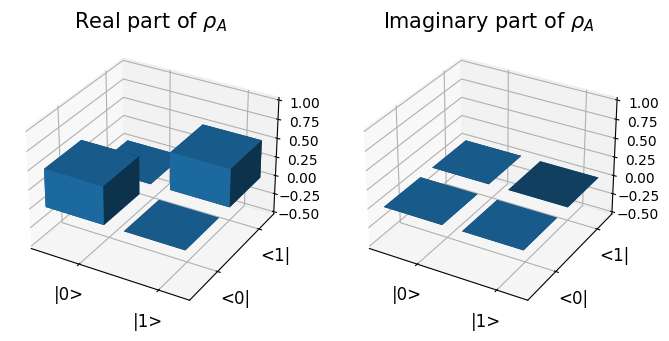

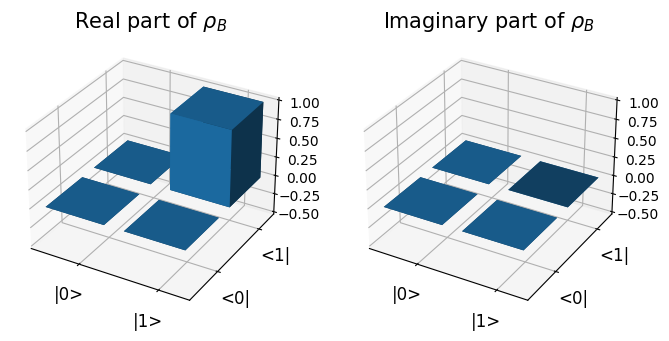

In [6]:
data = np.loadtxt('data_extended.txt')
features = data[:, :8]
n = np.random.randint(0, len(features))
rhoA, rhoB = feature_array_to_density_matrix(features[n,:])
visualize_features(rhoA, rhoB)

We now define the deep learning model. We choose to use a Multi-Layer Perceptron (MLP) with the following architecture:

1. Input layer: 8 neurons (same as the number of features);
2. Hidden layer: 50 neurons;
3. Hidden layer: 100 neurons;
4. Hidden layer: 200 neurons;
5. Hidden layer: 100 neurons;
6. Hidden layer: 50 neurons;
7. Output layer: 1 neuron (same as the number of targets to classify).

We also use the prettytable library to compute the number of trainable parameters and print a table with the number of parameters per layer.

In [7]:
model = torch.nn.Sequential(
    torch.nn.Linear(8, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 200),
    torch.nn.ReLU(),
    torch.nn.Linear(200, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 1),
    torch.nn.Sigmoid()
)

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
|  0.weight |    400     |
|   0.bias  |     50     |
|  2.weight |    5000    |
|   2.bias  |    100     |
|  4.weight |   20000    |
|   4.bias  |    200     |
|  6.weight |   20000    |
|   6.bias  |    100     |
|  8.weight |    5000    |
|   8.bias  |     50     |
| 10.weight |     50     |
|  10.bias  |     1      |
+-----------+------------+
Total Trainable Params: 50951


50951

As we can see from the table, the number of parameters is comparable with the size of the dataset.

Let's now turn to the training, validation, and test functions.
Since we are doing binary classification, the loss function is the **binary cross entropy**.
The optimizer is **Adam**, with learning rate 0.001. After some trials we noticed that the results are not much different if we use a different optimizer, such as the stochastic gradient descent.
Since the Adam optimizer can be implemented with less hyperparameters and it is a bit less sensitive to variations of the learning rate, we used it.
Finally, the metric to evaluate the performance of the model is the **accuracy**. Other values relevant for a classification prolem, such as the precision and the recall, will be discussed later.

In [8]:
def train_model(train_dl, model):

  model.train()

  running_loss = 0

  criterion = BCELoss()
  optimizer = Adam(model.parameters(), lr=0.001)
  for i, (inputs, targets) in enumerate(train_dl):

    optimizer.zero_grad()

    yhat = model(inputs)

    loss = criterion(yhat, targets)

    loss.backward()

    optimizer.step()

    running_loss += loss.item()

  train_loss = running_loss/len(train_dl)

  return train_loss

In [9]:
def validate_model(valid_dl, model):

  model.eval()

  running_loss = 0

  criterion = BCELoss()

  optimizer = Adam(model.parameters(), lr=0.001)

  for i, (inputs, targets) in enumerate(valid_dl):

    yhat = model(inputs)

    loss = criterion(yhat, targets)

    running_loss += loss.item()

  valid_loss = running_loss/len(valid_dl)

  return valid_loss

In [10]:
def test_model(test_dl, model):

    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):

        yhat = model(inputs)

        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))

        yhat = yhat.round()

        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)

    acc = accuracy_score(actuals, predictions)
    return acc

Now we train the algorithm for 50 epochs. We also gather the train and validation losses, so that we can plot them later.

In [11]:
epochs = 50

train_losses = []
valid_losses = []

for epoch in range(1, epochs+1):
  print('Epoch: ', epoch)
  train_loss = train_model(train_dl, model)
  train_losses.append(train_loss)
  valid_loss = validate_model(valid_dl, model)
  valid_losses.append(valid_loss)

acc = test_model(test_dl, model)
print('Accuracy: %.3f' % acc)

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Accuracy: 0.921


The **accuracy** of our classifier is **0.921**, or 92.1%, which means that in about 92% of the cases, the model classified correctly.
Let us now plot the loss curves, in particular train and validation loss curves, which is useful for a number of reasons.
If the slope of the training and validation loss, at the end of the training, is flat or almost flat, it means that convergence was reached, and there is not much more space of improvement, so we do not need to train the model for more epochs. Otherwise, we can increase the number of epochs and further reduce the training loss.
Furthermore, if at the end of the training we see that the validation and training loss do not follow the same trend, it can be a signal of overfitting, and in this case we would have to act on that and fix the problem.

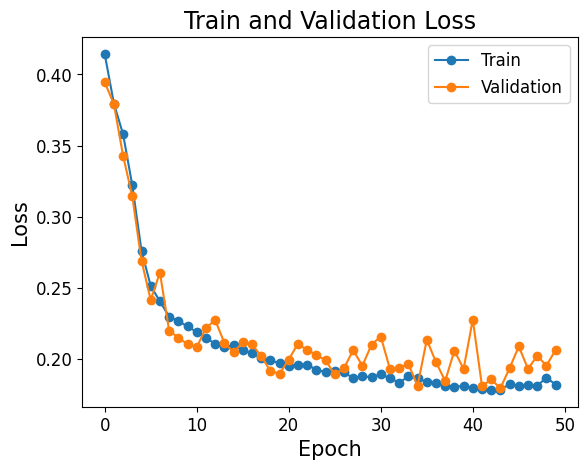

In [16]:
plt.plot(train_losses, '-o', label='Train')
plt.plot(valid_losses, '-o', label='Validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.title('Train and Validation Loss', fontsize=17)
plt.show()

From the plot of the loss curves we can see that, at the end of the training, both the curves are basically flat, so it is not useful to increase the number of epochs for the training. Furthermore, the behaviour of the two curves is very similar, without relevant signals of overfitting.

We now analyze the results of our classifier.
after the accuracy, it is important to look at the **ROC** (Receiver Operating Characteristic) **curve**, and the area under that curve.
This curve plots the true positive rat (TPR) with respect to the false positive rate (FPR), defined as:
\begin{equation}
\text{TPR} = \frac{\text{True Positive}}{\left( \text{True Positive} + \text{False Negative} \right)}
\end{equation}

\begin{equation}
\text{FPR} = \frac{\text{False Positive}}{\left( \text{False Positive} + \text{True Negative} \right)}
\end{equation}

The best value for the area under the curve is 1, which means that the model aalways correctly classify positive cases and never misclassify negative cases.
In our case, the "positive" label is 1, meaning that the state is mixed, while 0 is the "negative" label, which means that the state is pure.

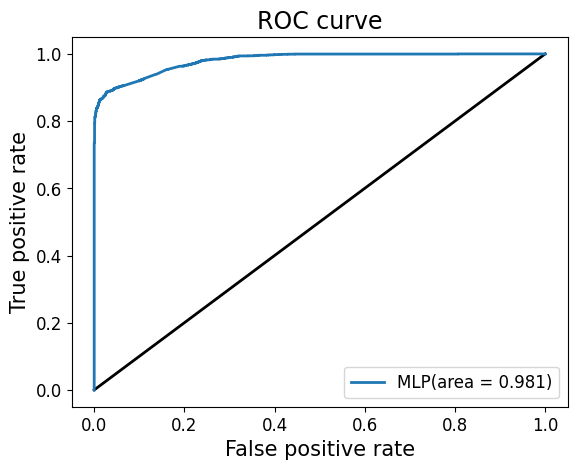

In [13]:
labels=['Pure', 'Mixed']

data = np.loadtxt(filename)
X = data[:, :-1].astype('float32')
y = data[:, -1]
y = y.reshape((len(y), 1))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

y_true = y_val
y_pred = model(torch.from_numpy(X_val))
y_pred = y_pred.detach().numpy()

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-', linewidth=2)
plt.plot(fpr, tpr, label='MLP(area = {:.3f})'.format(roc_auc), linewidth=2)
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('ROC curve', fontsize=17)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.show()

The **area under the ROC curve** is **0.981**, which is close to 1, confirming that the performance of the model are very good, as suggested from the accuracy.

We can also look at the **confusion matrix** to evaluate the performance of our model.

True negative cases: 2428
False positive cases: 66
False negative cases: 288
True positive cases: 2218


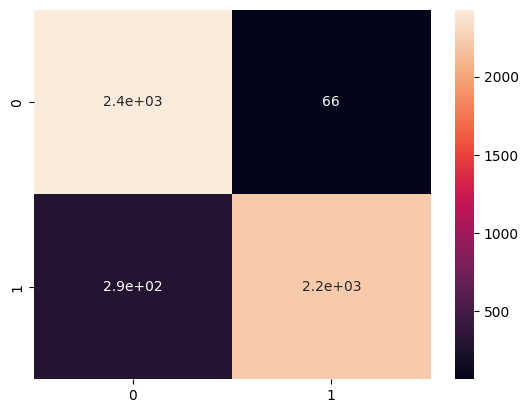

In [14]:
cf_matrix = confusion_matrix(y_true, y_pred.round())

sns.heatmap(cf_matrix, annot=True)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred.round()).ravel()
print('True negative cases:', tn)
print('False positive cases:', fp)
print('False negative cases:', fn)
print('True positive cases:', tp)

In this matrix the number of true positive, true negative, false positive, and false negative cases, is reported. This is another way to see that the performance of our model is very good. However, we can see that the number of false negative cases is larger than the number of false positive cases. This means that our model classify mixed states as pure more often than pure states as mixed.

Finally, we can look at the **recall** and the **precision** of our model.
The **precision** is defined as:
\begin{equation}
\text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
\end{equation}
It represents the proportion of positive identifications that was actually correct.
The **recall** is a synonym for true positive rate, defined as:
\begin{equation}
\text{Recall} = \frac{\text{TP}}{\text{TP + FN}}
\end{equation}
It represents the proportion of actual positives that was correctly identified.

In [15]:
precision = precision_score(y_true, y_pred.round())
print('Precision:', precision.round(2))
recall = recall_score(y_true, y_pred.round())
print('Recall:', recall.round(2))

Precision: 0.97
Recall: 0.89


The **precision** of our model is **0.97**, or 97%. It means that when the model predicts a state as mixed, it is correct 97% of the time.
The **recall** of our model is **0.89**, or 89%. It means that the model correctly classify 89% of all mixed states.

We have proved that a deep learning algorithm, in particular a multi-layer perceptron, can be trained to properly classify quantum states as pure or mixed, using as features the real parameters characterizing the single-qubit reduced density matrices.
We evaluated the performance of this model by computing all the usual metrics of a binary classification task, such as the accuracy, the area under the ROC curve, the precision, and the recall.
This work can be an important step toward a faster characterization of quantum states.
One possible extensions could be to consider systems with more than 2 qubits and different reduced density matrices, such as 3-qubit systems and 1-qubit and 2-qubit reduced density matrices.